<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-DavRo24/blob/main/Proyecto-parcial/Proyecto_parcial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install corner
!pip install emcee
!pip install scienceplots

In [2]:
!pip install simplemc

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scienceplots
import emcee
import corner

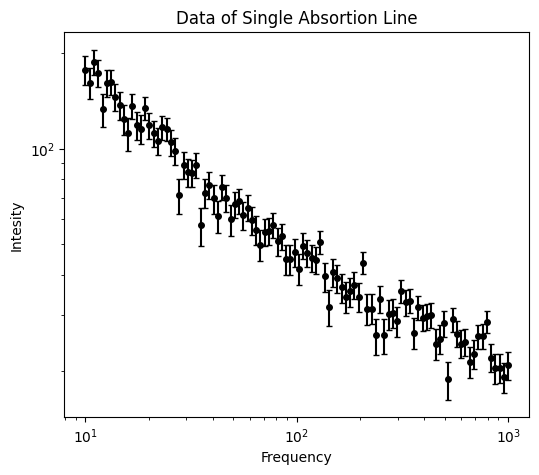

In [4]:
data = np.loadtxt('/content/drive/MyDrive/Machine-Learning-2023/synthetic_data2.txt').T #Carga de datos

x, y, yerr = data
#Ploteando
fig = plt.figure(figsize=(6,5))
plt.errorbar(x, y, yerr = yerr, marker='o', markersize=4,linestyle='none',mfc='black',mec='black',
			 capsize= 2, color='black')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Intesity', fontsize = 10)
plt.xlabel('Frequency', fontsize = 10)
plt.title('Data of Single Absortion Line')
plt.show()

In [5]:
# Definición de la función del modelo con parámetros y variable independiente
def model(parameters, x):
    a, b, c, d, e = parameters

    return (a - b * np.exp(-(x - c) ** 2 / (2 * d ** 2))) * x ** (-e)

# Función para calcular el logaritmo natural de la verosimilitud (ln-likelihood)
def lnlike(x, y, yerr, theta, model=model):
    # Cálculo del logaritmo natural de la verosimilitud
    log_likelihood = -1/2 * np.sum((y - model(theta, x)) ** 2 / yerr ** 2)
    return log_likelihood

# Función para calcular el logaritmo natural de la probabilidad a priori (ln-prior)
def lnprior(theta):
    a, b, c, d, e = theta

    # Definición de los rangos permitidos para los parámetros
    if (700.0 < a < 1200.0) and (500.0 < b < 800.0) and (1.0 < c < 6.0) and (0.15 < d < 3.0) and (0.0 < e < 3.0):
        return 0  # Devuelve 0 si los parámetros están dentro de los rangos permitidos
    return -np.inf  # Devuelve menos infinito si algún parámetro está fuera de rango

# Función para calcular el logaritmo natural de la probabilidad conjunta (ln-posterior)
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)  # Calcular el ln-prior para los parámetros
    if not np.isfinite(lp):
        return -np.inf  # Devuelve menos infinito si el ln-prior no es finito
    return lp + lnlike(x, y, yerr, theta)  # Devuelve la suma del ln-prior y ln-likelihood


In [6]:
#implementación del modelo MCMC

np.random.seed(0)

nchains = 60
dims = 5
samples = 10000


coefs_iniciales=np.array([875.0, 600.0, 0.5, .3, 1.5])

initial_parameters = coefs_iniciales + 1e-1 * np.random.randn(nchains, dims)


sampler = emcee.EnsembleSampler(nchains, dims, lnprob, args=(x, y, yerr))


sampler.run_mcmc(initial_parameters, samples,progress=True);

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [00:36<00:00, 274.97it/s]


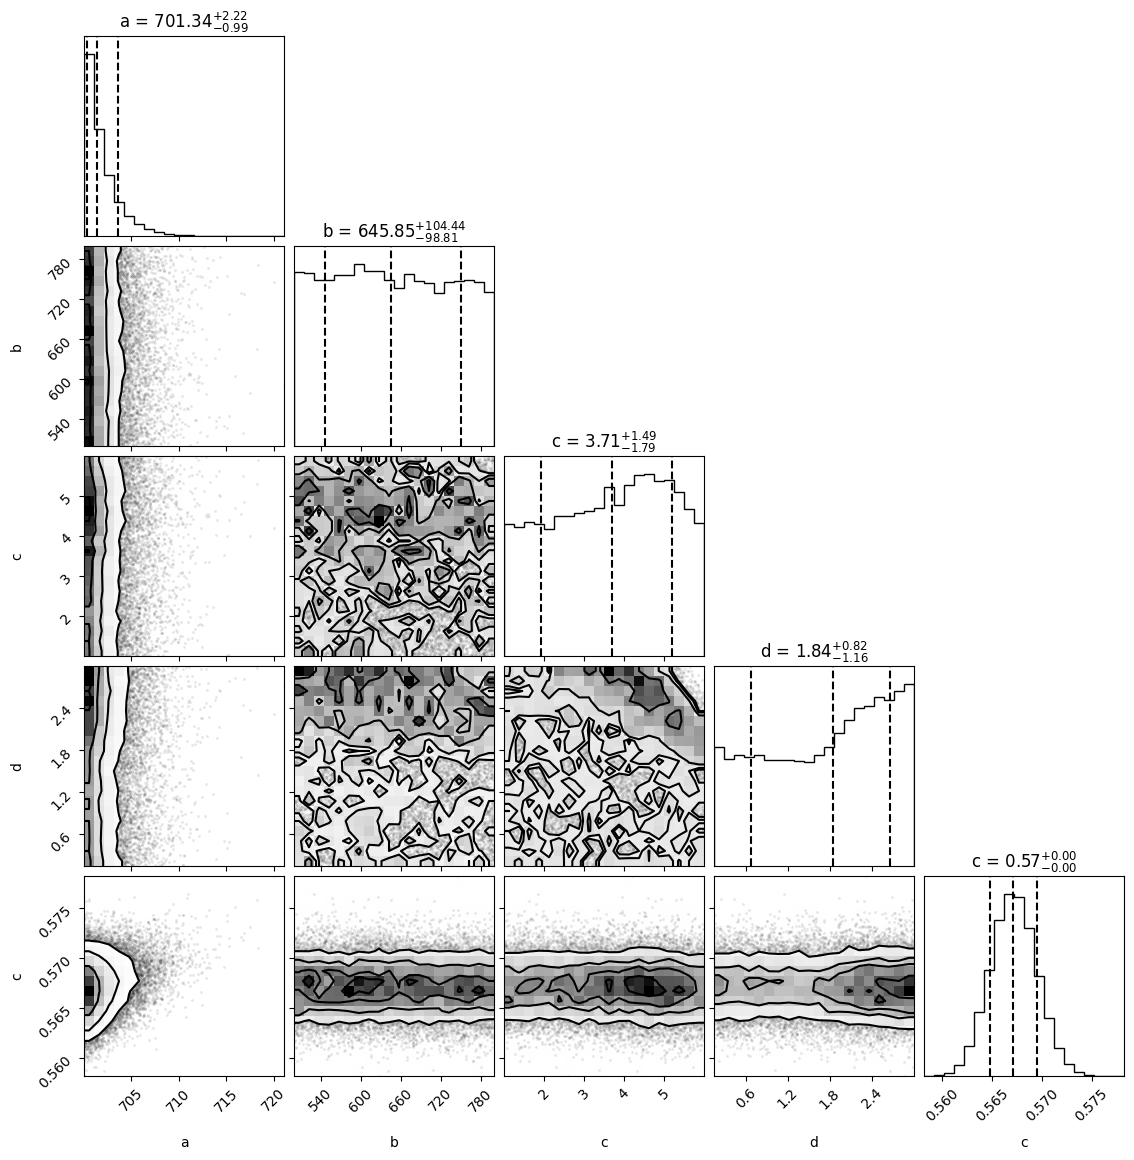

In [7]:
import corner

chains = sampler.get_chain(discard=3000, thin=20, flat=True)

labels = ["a", "b", "c", "d", "c"]

fig = corner.corner(chains, labels=labels, show_titles=True, fontsize =12, quantiles=[0.16, .5, .84]);

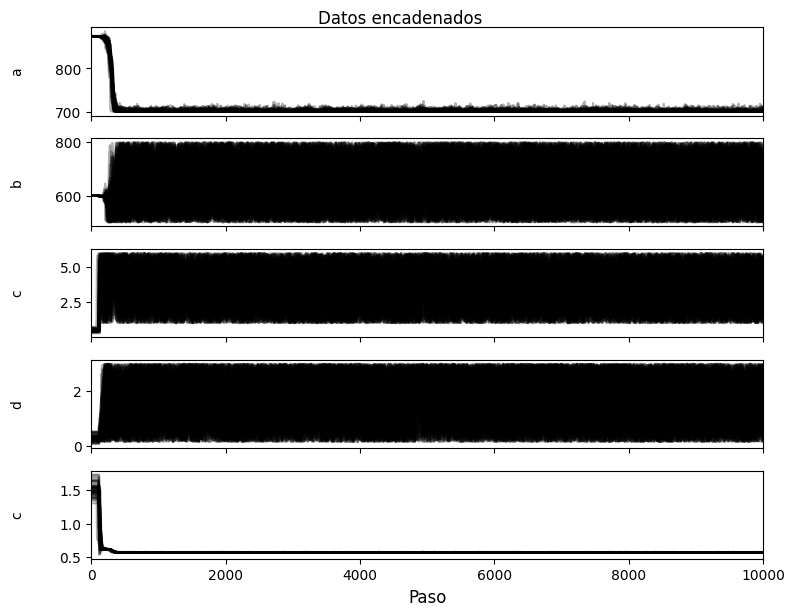

In [8]:
# Obtener la cadena de Markov sin descartar ninguna muestra
chains = sampler.get_chain()

# Crear una figura con múltiples subtramas, una para cada parámetro
fig, axes = plt.subplots(len(labels), figsize=(8, 6), sharex=True)

# Establecer el título principal de la figura
fig.suptitle("Datos encadenados")

# Iterar sobre los parámetros para trazar las cadenas de Markov
for i in range(len(labels)):
    ax = axes[i]
    ax.plot(chains[:, :, i], "k", alpha=0.3)

    # Establecer los límites de los ejes x en función del número de pasos
    ax.set_xlim(0, len(chains))

    # Etiquetar el eje y con el nombre del parámetro correspondiente
    ax.set_ylabel(labels[i])

    # Ajustar la posición de las etiquetas del eje y para una mejor visualización
    ax.yaxis.set_label_coords(-0.1, 0.5)

# Ajustar el diseño general de la figura
plt.tight_layout()

# Ajustar el espacio en la parte superior de la figura para dar lugar al título
plt.subplots_adjust(top=0.95)

# Etiquetar el eje x con "Step" y especificar el tamaño de fuente
axes[-1].set_xlabel('Paso', fontsize=12)

# Mostrar la figura con las cadenas de Markov
plt.show()


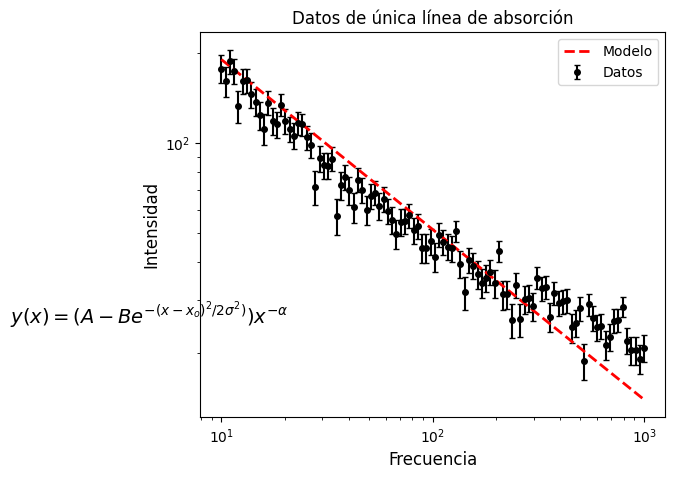

In [9]:
# Obtener la cadena de Markov generada por el algoritmo de muestreo
chains = sampler.get_chain(discard=3000, thin=20, flat=True)

# Calcular los valores promedio de los parámetros a lo largo de la cadena
weights = np.mean(chains, axis=0)

# Crear una figura de Matplotlib con un tamaño específico
fig = plt.figure(figsize=(6, 5))

# Trazar los datos observados con barras de error
plt.errorbar(x, y, yerr=yerr, marker='o', markersize=4, linestyle='none', mfc='black', mec='black',
             capsize=2, color='black', label='Datos')

# Trazar el modelo utilizando los valores de parámetros "óptimos" en una línea discontinua
plt.plot(x, model(weights, x), linestyle='--', color='r', label='Modelo', linewidth=2)

# Cambiar la escala de los ejes x e y a logarítmica
plt.xscale('log')
plt.yscale('log')

# Mostrar la leyenda en el gráfico
plt.legend()

# Etiquetar el eje y como "Intensidad" y el eje x como "Frecuencia" con tamaños de fuente específicos
plt.ylabel('Intensidad', fontsize=12)
plt.xlabel('Frecuencia', fontsize=12)

# Agregar texto en el gráfico para mostrar la ecuación del modelo
plt.text(1, 25, r'$y(x) = (A- Be^{-(x-x_o)^2 /2σ^2)})x^{-α}$', fontsize=14)

# Establecer el título del gráfico
plt.title('Datos de única línea de absorción')

# Mostrar el gráfico resultante
plt.show()


In [10]:
def mc(x, y, yerr, n_iter, initial, sigmas):
    chain = [initial]  # Inicializa la cadena con el valor inicial.
    theta_old = initial  # Establece el valor inicial como el valor anterior.
    reject = []  # Inicializa una lista para almacenar los valores rechazados.
    accept = []  # Inicializa una lista para almacenar los valores aceptados.

    for _ in range(n_iter):
        theta_new = [theta_old[i] + np.random.normal(0, sigmas[i]) for i in range(5)]
        # Genera un nuevo conjunto de parámetros theta_new al agregar ruido normal a cada parámetro de theta_old.

        p_new = lnprob(theta_new, x, y, yerr)  # Calcula la probabilidad logarítmica del nuevo conjunto de parámetros.
        p_old = lnprob(theta_old, x, y, yerr)  # Calcula la probabilidad logarítmica del conjunto de parámetros anterior.

        if p_new > p_old:  # Si la nueva probabilidad es mayor que la anterior, acepta el nuevo conjunto de parámetros.
            chain.append(theta_new)
            accept.append(theta_new)
            theta_old = theta_new  # Actualiza el valor anterior al nuevo valor aceptado.
        else:
            r = np.random.random()
            pn = p_new - p_old
            # Calcula la diferencia entre las probabilidades logarítmicas (Metropolis-Hastings ratio).

            if pn > np.log(r):  # Si la diferencia es mayor que el logaritmo de un número aleatorio, acepta el nuevo conjunto de parámetros.
                chain.append(theta_new)
                accept.append(theta_new)
                theta_old = theta_new  # Actualiza el valor anterior al nuevo valor aceptado.
            else:
                chain.append(theta_old)  # Si no se cumple ninguna de las condiciones anteriores, conserva el valor anterior.
                reject.append(theta_new)  # Agrega el nuevo conjunto de parámetros a la lista de rechazados.

    chain = np.array(chain)  # Convierte la cadena en un arreglo NumPy.
    print('Fraction Rejected:', len(reject) / len(chain), len(reject))
    print('Fraction Accepted:', len(accept) / len(chain), len(accept))
    return chain  # Devuelve la cadena de parámetros resultante.


In [11]:
import numpy as np

# Definir el número de puntos de datos
num_points = 100

# Crear un array para las x que será el eje de frecuencia
# Usar una escala logarítmica para simular datos de frecuencia
x = np.logspace(1, 3, num_points)

# Definir parámetros reales del modelo que queremos recuperar
# Estos valores deberían ser consistentes con los priors definidos en el código
a_real = 1000
b_real = 650
c_real = 3.5
d_real = 1.5
e_real = 2.0

# Generar datos utilizando un modelo no lineal con ruido gaussiano
# Agregamos una componente logarítmica al modelo para asegurar que los datos sean no negativos
y_true = (a_real - b_real * np.exp(-(x - c_real)**2 / (2 * d_real**2))) * np.log(x + 1e-3) ** (-e_real)
yerr = 0.1 * y_true  # Error del 10% de los valores verdaderos
y_obs = y_true + yerr * np.random.randn(num_points)  # Observaciones con ruido


In [12]:
x, y, yerr = data
n_iter = 1000000
initial_guess = [875.0, 600.0, 0.5, .3, 1.5]
sigmas = [15.0, 10.0, .1, .2, .2]

In [13]:
cad = mc(x, y, yerr, n_iter, initial_guess, sigmas)
cad = cad[10000:]

Fraction Rejected: 0.999999000001 1000000
Fraction Accepted: 0.0 0


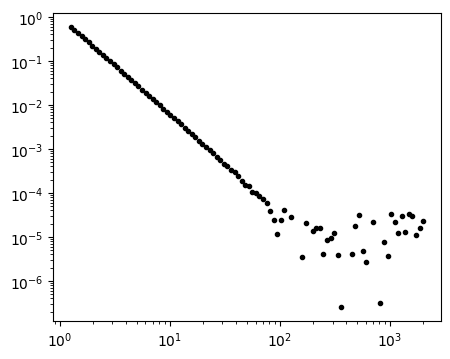

In [14]:
def model_two(parameters, x):
  a, b, c, d = parameters
  y = (np.exp(-(x-1)/a)/(x**b)+c*np.exp(-(x-1)/d)/(x**(-b)))
  return y

np.random.seed(41)

real_params = [266,2.2, 1e-11, 1e3]

x_aux = np.logspace(.1,3.3, 100)
y = model_two(real_params, x_aux) + np.random.normal(0, 1e-5, size = 100)
yerr =  np.random.normal(0, 1e-2, size = 100)
f = plt.figure(figsize=(5,4))
plt.plot(x_aux, y, 'k', marker = '.', ls = 'none')
plt.yscale('log')
plt.xscale('log')

In [15]:
def lnlike(x, y, theta, model=model_two):
  log = -1/2*np.sum((y- model(theta, x))**2/yerr**2+ np.log(yerr**2))
  return log

def lnprior(theta):
  a, b, c, d = theta

  if (100.0 < a < 300.0) and (1.0 < b < 3.0) and (-1 < c < 1) and (600.0 < d < 1200.0):
    return 0
  return -np.inf

def lnprob(theta, x, y):
	lp = lnprior(theta)
	if not np.isfinite(lp):
		return -np.inf
	return lp + lnlike(x, y, theta)

In [16]:
nchains = 40 #Numero de cadenas
dims = 4     # Se van a estimar 4 parametros: w0,w1,w2 y w3
samples = 1500  # Número de pasos por cadena

coefs_iniciales=np.array([150.0, 1.2, 0, 650.0])

# Parámetros iniciales para las cadenas
initial_parameters = coefs_iniciales + 1e-5*np.random.randn(nchains, dims)

# Crear el objeto emcee.EnsembleSampler
sampler = emcee.EnsembleSampler(nchains, dims, lnprob, args=(x_aux, y))

# Ejecutar el MCMC
sampler.run_mcmc(initial_parameters, samples,progress=True);

100%|██████████| 1500/1500 [00:07<00:00, 194.33it/s]


In [18]:
samples = sampler.get_chain(discard=100, thin=10, flat=True)
samples.shape

(5600, 4)

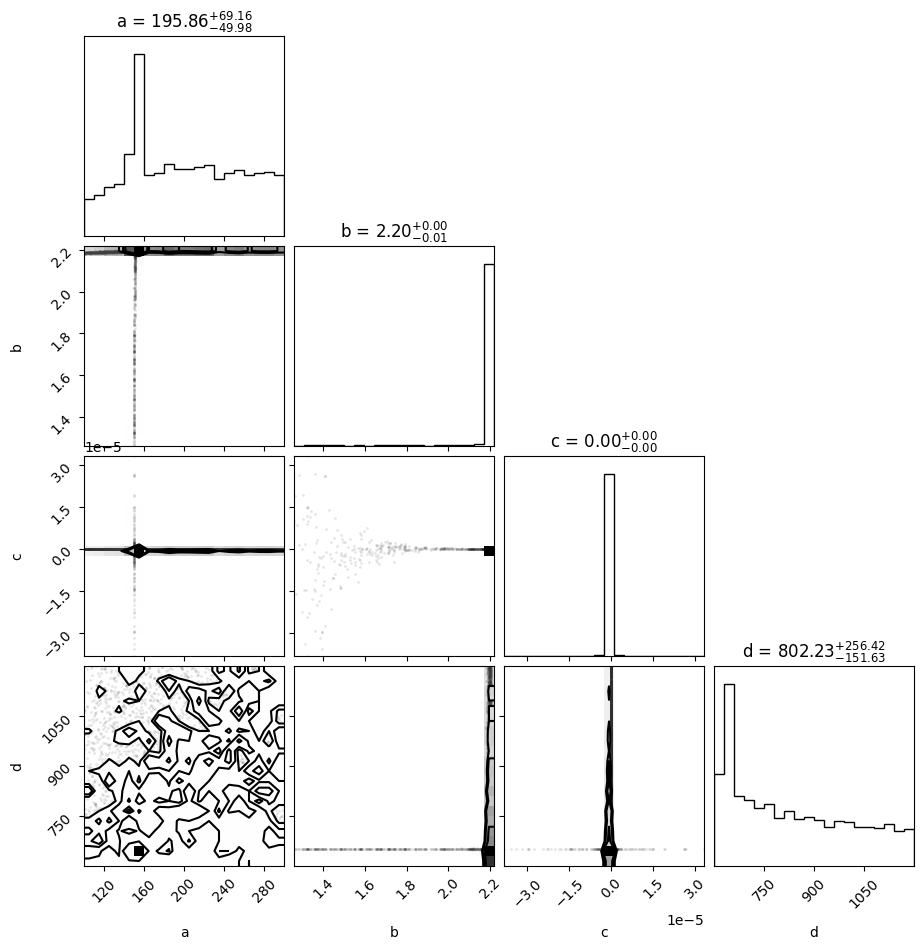

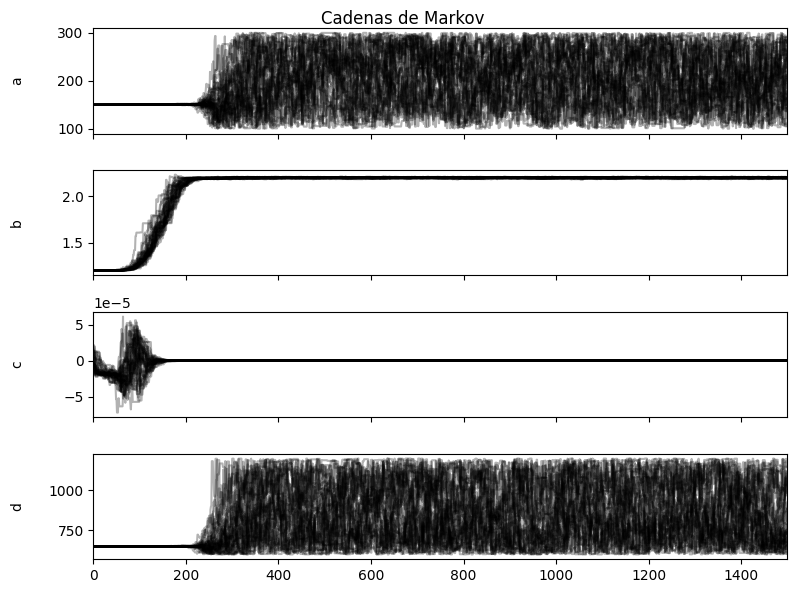

In [19]:
samples = sampler.get_chain(discard=100, thin=10, flat=True)
#cadena descartando 100 muestras, manteniendo una de cada 10 muestras y aplanando
param_names = ["a", "b", "c", "d"]

fig = corner.corner(samples, labels=param_names, show_titles=True)
#crear triangle plot con corner, son las graficas que parecen un camino

samples = sampler.get_chain()
#nuevamente cargo la cadena, PERO sin descartar ninguna muestra

# Configurar subtramas para cada parámetro
fig, axes = plt.subplots(len(param_names), figsize=(8, 6), sharex=True)
fig.suptitle("Cadenas de Markov")

# grafuci cada cadena, aqui es donde no descarto nada
for i in range(len(param_names)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(param_names[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

In [28]:
!git clone https://github.com/ja-vazquez/SimpleMC.git

Cloning into 'SimpleMC'...
remote: Enumerating objects: 5747, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 5747 (delta 38), reused 52 (delta 24), pack-reused 5671
Receiving objects: 100% (5747/5747), 102.76 MiB | 20.58 MiB/s, done.
Resolving deltas: 100% (3594/3594), done.


In [34]:
!cd SimpleMC

!pip install -e


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

-e option requires 1 argument


In [ ]:
!pip3 install -e git+https://github.com/ja-vazquez/SimpleMC#egg=simplemc

In [ ]:
from simplemc.cosmo.Parameter import Parameter

from simplemc.DriverMC import DriverMC

a = Parameter("a", 500, 0.05, (0, 1000.0), "A")
b = Parameter("b", 500, 0.05, (0, 1000.0), "B")
xo = Parameter("x", 2.5, 0.05, (-2.0, 5.0), "x_0")
sigma = Parameter("s", 2.5, 0.05, (-2,0, 5.0), "\sigma")
alpha = Parameter("al", 2.5, 0.05, (-2.0, 5.0), "\alpha")

# create a list with your parameters objects
parameterlist = [a, b, xo, sigma, alpha]

def model(parameters, x):
  a, b, c, d, e = parameterlist

  return (a-b*np.exp(-(x-c)**2/(2*d**2)))*x**(-e)

In [ ]:
!python --version

In [ ]:
my_model = '(a-b*np.exp(-(x-xo)**2/(2*sigma**2)))*x**(-alpha)'

analyzer = DriverMC(model='simple', datasets='generic', analyzername='mcmc',
                    custom_parameters=parameterlist, custom_function=my_model,
                    path_to_data='/content/drive/MyDrive/Machine-Learning-2023/synthetic_data3.txt', fn='generic')

analyzer.executer(nsamp=1000)

In [26]:
np.random.seed(45)

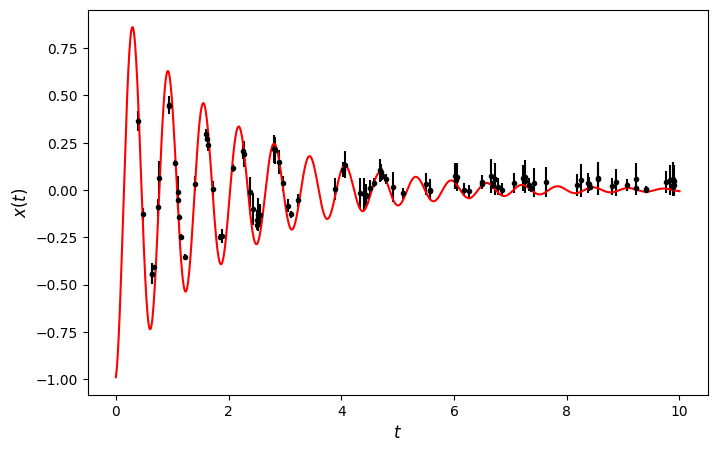

In [27]:
def damped_oscilator(theta, t):
  a, b, c = theta
  y = np.exp(-a*t)*np.cos(b*t - c)
  return y

#True_Values
a_true = .5
b_true = 10
c_true = 3

real_values = [a_true, b_true, c_true]

t = np.sort(10 * np.random.rand(100))
yerr = 0.01 + .08*np.random.rand(100)
y = damped_oscilator(real_values, t)*np.random.rand() + yerr*np.random.rand()

f = plt.figure(figsize = (8, 5))
t0 = np.linspace(0, 10, 1000)
plt.errorbar(t, y, yerr = yerr, marker = '.',
             linestyle='none', color = 'k')
#plt.plot(t, damped_oscilator(real_values, t), '.', color = 'black')
plt.plot(t0, damped_oscilator(real_values, t0), '-', color = 'red')

plt.ylabel(r'$x(t)$', fontsize = 12)
plt.xlabel(r'$t$', fontsize = 12)
plt.show()